# Multi-head attention

The multi-head attention is a componet of the transfoermer. It is composed of multiple "Scaled Dot-product attention". 

<div style="display:flex; justify-content:space-between; max-width:850px">
    <img src="imgs/transformer.png" width="400"/>
    <img src="imgs/multi-head-attention.png" width="400" height="350"/>
</div>


In [122]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## Inputs

In [123]:
# Length of the input sequence
sequence_length = 4

batch_size = 1

# Input dimension of the vectors that go into the attention unit
input_dim = 512

# Output dimension of the attention unit
attention_output_dim = 512

# Since we do not calculate the positional encodings here,
# X represent the values (input + position embedding) 
# that are gonna be fed directly to the transformer
X = torch.randn(batch_size, sequence_length, input_dim)
X.shape

torch.Size([1, 4, 512])

## Multi-head attention

### 1. Linear Layer

In [150]:
linear_layer_in = nn.Linear(
    in_features=input_dim, out_features=attention_output_dim * 3     # 3 because we have 3 vectors Q, K, V
)

print(linear_layer_in)

QKV = linear_layer_in(X)
QKV.shape

Linear(in_features=512, out_features=1536, bias=True)


torch.Size([1, 4, 1536])

Visualizing the tensor values distribution

Text(0.5, 1.0, 'QKV distribution')

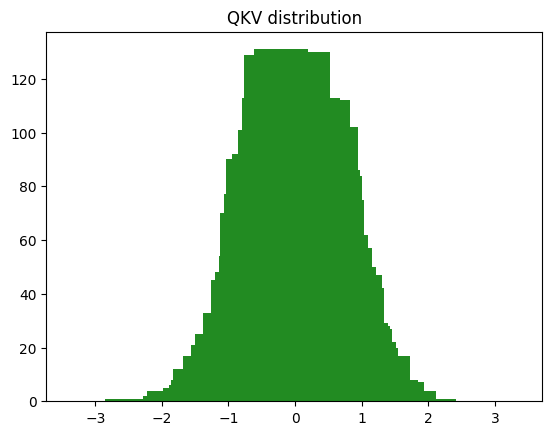

In [125]:
import matplotlib.pyplot as plt

y_val = torch.histc(QKV, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('QKV distribution')

### 2. Scaled Dot-Product Attention

We create an attention module with:
- 8 heads
- A head dimension of 64 (our input dimension is 512 / 8 heads = 64).
-  A sequence length of 4

In [126]:
n_heads = 8
head_dim = attention_output_dim // n_heads

print(f"{n_heads} heads")
print(f"Head dimension: {head_dim}      # Each word will be represented as a 64 dimensional vector in a head.")

QKV = QKV.reshape(
    # batch_size, sequence_length, n_heads, head_dim * 3
    batch_size, n_heads, sequence_length, head_dim * 3
)
# For easier parallel processing, put the head before
# QKV.permute(0, 2, 1, 3).shape

print(f"QKV.shape: {QKV.shape}")


8 heads
Head dimension: 64      # Each word will be represented as a 64 dimensional vector in a head.
QKV.shape: torch.Size([1, 8, 4, 192])


**Get Query, Key, and Value vectors**

We can now extract the Query, Key and Value vectors from `QKV`.

In [143]:
# Run this code to see how to extract values on a particular dimension from a tensor
# t = torch.rand([2, 2, 3])
# print(t)
# t.chunk(3, dim=-1)

In [144]:
# Extract Q, K, V by breaking the last 
# dimension of QKV into 3 chunks
Q, K, V = QKV.chunk(3, dim=-1)

print(f"QKV.shape: {QKV.shape}")
print(f"Q, K, V shapes: {Q.shape, K.shape, V.shape}")
print(f"N heads: {Q.shape[1]}")
print(f"Sequence Length: {Q.shape[2]}")
print(f"Head dimension: {Q.shape[3]}")

QKV.shape: torch.Size([1, 8, 4, 192])
Q, K, V shapes: (torch.Size([1, 8, 4, 64]), torch.Size([1, 8, 4, 64]), torch.Size([1, 8, 4, 64]))
N heads: 8
Sequence Length: 4
Head dimension: 64


Now let's compute the self-attention

> Matmul > Scale > Mask > Softmax > Matmul

$$
\begin{aligned}
\text { Attention }(Q, K, V) &=\operatorname{softmax} \left(\frac{Q. K^{T}} {\sqrt{d_{k}}} + M \right) V \\
\end{aligned}
$$

**Matmul**

In [128]:
print(f"K: {K.shape}")
# Not suitable for tensors (Swap all dimensions)
print(f"K Transposed (Wrong): {K.T.shape}")
# Swap the last two dimension (Same result, dimensions are the same)
print(f"K Transposed: {K.transpose(-2, -1).shape}")
print(f"K Transposed: {K.transpose(-1, -2).shape}")

K: torch.Size([1, 8, 4, 64])
K Transposed (Wrong): torch.Size([64, 4, 8, 1])
K Transposed: torch.Size([1, 8, 64, 4])
K Transposed: torch.Size([1, 8, 64, 4])


In [129]:
head_dim = Q.shape[-1]     # head dim, Q last dim

scaled = torch.matmul(
    Q, K.transpose(-2, -1)
) / np.sqrt(head_dim)

scaled.shape

torch.Size([1, 8, 4, 4])

**Masking**

In [130]:
scaled.shape

torch.Size([1, 8, 4, 4])

In [131]:
mask = torch.full(scaled.shape, -torch.inf)
mask = torch.triu(mask, diagonal=1)
mask[0][0]  # mask of the first head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [132]:
(scaled + mask)[0][0]

tensor([[-0.2027,    -inf,    -inf,    -inf],
        [-0.4861, -0.1218,    -inf,    -inf],
        [ 0.0859, -0.2417,  0.2456,    -inf],
        [ 0.1029, -0.9370, -0.0714,  0.1687]], grad_fn=<SelectBackward0>)

In [133]:
masked_scaled = scaled + mask

**Softmax**

In [134]:
attention_weights = F.softmax(masked_scaled, dim=-1)
attention_weights.shape

torch.Size([1, 8, 4, 4])

**Attention**

The ideas is to obtain new values vector that are much more context aware than the original values vector.

Now we multiply the softmax scores with the values vector to get the new values.

The shape [1, 8, 4, 64] means:
- 8 heads
- Each head takes in 4 words
- Each word is encoded as a 64 dimensionnal vector in a single head

In [135]:
print(f"Attention weights:", attention_weights.shape)
print(f"V:", V.shape)

attention_output  = torch.matmul(attention_weights, V)
attention_output .shape

Attention weights: torch.Size([1, 8, 4, 4])
V: torch.Size([1, 8, 4, 64])


torch.Size([1, 8, 4, 64])

### 3. Concatenation

Now we concatenate the outputs of the 8 heads to get a single vector of shape [1, 4, 512].

In [148]:
attention_output = attention_output.reshape(
    batch_size, sequence_length, n_heads*head_dim
)

attention_output.shape

torch.Size([1, 4, 512])

### 4. Linear

We pass the output to a dense layer so that the heads can communicate with each other.

In [152]:
linear_layer_out = nn.Linear(attention_output_dim, attention_output_dim)
linear_layer_out

out = linear_layer_out(attention_output)
out.shape

torch.Size([1, 4, 512])

## References

- [Attention is all you need, Ashish Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
- [CodeEmporium - Multi Head Attention in Transformer Neural Networks with Code!](https://www.youtube.com/watch?v=HQn1QKQYXVg&list=PLTl9hO2Oobd97qfWC40gOSU8C0iu0m2l4&index=2)